## 1. Preparations
- 아래 첫번째 셀 실행후 위에서 런타임-> 런타임 다시 시작 클릭

In [35]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm
!pip install torchdata

2023-06-25 13:16:56.713135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 26.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
2023-06-25 13:17:12.426197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import torchtext
print(torchtext.__version__)

0.15.2+cpu


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data
#from torchtext.data import Field
from torchtext import datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab
from torchtext.datasets import Multi30k
from typing import Iterable, List
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.utils import download_from_url, extract_archive
from collections import Counter



import spacy
import numpy as np

import random
import math
import time
import io

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

##Create Source and Target Tokenizer

In [39]:
spacy_de= spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')


In [40]:
tokenizer_de= get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en= get_tokenizer('spacy', language='en_core_web_sm')

In [41]:
tokenizer_en("he was bored")

['he', 'was', 'bored']

##Load Data

In [42]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving test.json to test (1).json
Saving train.json to train (1).json
Saving valid.json to valid (1).json
User uploaded file "test.json"
User uploaded file "train.json"
User uploaded file "valid.json"


In [43]:
import json
train_data= [json.loads(line) for line in open('./train.json', encoding="utf-8")]
valid_data= [json.loads(line) for line in open('./valid.json', encoding="utf-8")]
test_data = [json.loads(line) for line in open('./test.json', encoding="utf-8")]


train: 29000

valid: 1014

test: 1000

In [44]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

29000
1014
1000


In [45]:
print(type(train_data[0]))
print(train_data[1])
print(' '.join(train_data[1]['src']))

<class 'dict'>
{'src': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.'], 'trg': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.']}
several men in hard hats are operating a giant pulley system .


In [46]:
datasets=[train_data, valid_data, test_data]
import string

for dataset in datasets:
  for i in dataset:
    i['src']=' '.join(i['src'])
    i['trg']=' '.join(i['trg'])



In [47]:
print(train_data[100])
print(test_data[100])

{'src': 'toddler boy in a red hat holding on to some railings .', 'trg': 'männliches kleinkind in einem roten hut , das sich an einem geländer festhält .'}
{'src': 'a happy woman is preparing a refreshment at a coffee shop .', 'trg': 'eine glückliche frau bereitet in einem coffee - shop eine erfrischung zu .'}


##Create Vocabulary

In [48]:
from collections import Counter
from torchtext.vocab import vocab

counter_de = Counter()
counter_en = Counter()
for i in train_data:
  counter_en.update((tokenizer_en(i['src'])))
  counter_de.update((tokenizer_de(i['trg'])))
vocab_de = vocab(counter_de, min_freq=1, specials=("<unk>", '<BOS>', '<EOS>', '<PAD>'))
vocab_en = vocab(counter_en, min_freq=1, specials=("<unk>", '<BOS>', '<EOS>', '<PAD>'))
vocab_de.set_default_index(vocab_de["<unk>"])
vocab_en.set_default_index(vocab_en["<unk>"])

In [49]:
vocab_en.get_default_index()

0

In [50]:
vocab_de.get_default_index()

0

In [51]:
print("The length of the new vocab is", len(vocab_de))
new_stoi = vocab_de.get_stoi()
print("The index of '<BOS>' is", new_stoi['<BOS>'])
new_itos = vocab_de.get_itos()
print("The token at index 2 is", new_itos[2])
print("The token at index 3 is", new_itos[3])
print("The token at index 100 is", new_itos[100])

The length of the new vocab is 17981
The index of '<BOS>' is 1
The token at index 2 is <EOS>
The token at index 3 is <PAD>
The token at index 100 is orangefarbenen


In [52]:
print("The length of the new vocab is", len(vocab_en))
new_stoi2 = vocab_en.get_stoi()
print("The index of '<BOS>' is", new_stoi2['<BOS>'])
new_itos2 = vocab_en.get_itos()
print("The token at index 2 is", new_itos2[1])
print("The token at index 3 is", new_itos2[3])
print("The token at index 100 is", new_itos2[100])

The length of the new vocab is 9793
The index of '<BOS>' is 1
The token at index 2 is <BOS>
The token at index 3 is <PAD>
The token at index 100 is women


# 2. Data Loader


In [53]:
trg_transform = lambda x: [vocab_de['<BOS>']] + [vocab_de[token] for token in tokenizer_de(x)] + [vocab_de['<EOS>']]
src_transform = lambda x: [vocab_en['<BOS>']] + [vocab_en[token] for token in tokenizer_en(x)] + [vocab_en['<EOS>']]

In [54]:
# trg_transform = lambda x: [vocab_de['<BOS>']] + [vocab_de[token] for token in tokenizer(x)] + [vocab_de['<EOS>']]
# src_transform = lambda x: [vocab_en['<BOS>']] + [vocab_en[token] for token in x] + [vocab_en['<EOS>']]

In [55]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
   src_list, trg_list = [], []
   for i in batch:

        src_text = torch.tensor(src_transform(i['src']))
        src_list.append(src_text)
        trg_text = torch.tensor(trg_transform(i['trg']))
        trg_list.append(trg_text)
   return pad_sequence(src_list, padding_value=3.0).to(device), pad_sequence(trg_list, padding_value=3.0).to(device)



train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)

In [56]:
print(src_transform(train_data[2]['src']))
trg_transform(train_data[2]['trg'])

[1, 21, 25, 26, 27, 28, 21, 29, 30, 14, 2]


[1, 22, 24, 25, 26, 12, 22, 27, 28, 29, 17, 2]

In [57]:
a=[1, 21, 25, 26, 27, 28, 21, 29, 30, 14, 2]
[new_itos2[x] for x in a]

['<BOS>',
 'a',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 '.',
 '<EOS>']

In [58]:
#print(next(iter(train_dataloader)))
print(next(iter(train_dataloader))[0])
print(next(iter(train_dataloader))[0].size())
print(next(iter(train_dataloader))[1].size())

tensor([[   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1],
        [  21,  208,   21,  208,   21,   21,   21,   21,   65, 7968,  660,   21,
           21,   21,    4,  167,   21,   21,   41,   21,  120,   21,   21,   21,
           21,  100,    4,   21,  373,   84,   21,   21],
        [  63, 2770,  456,  537,  999,  527,   25,  250, 1275,  159,   34,   63,
          250,   31,   70,   17,  103,   31,   84,  250,    9,   31,   63,   31,
           31,   17,   79,   90, 2878,  413,  382, 4202],
        [  92,   31,   25,  457,  136,  464,  241,   74,   74,  148,   21,   64,
           74,   17,   17,   32,   64,   17,   16,   74,  231,  110,   92,  196,
           17,  978,    9,   91, 2760,  587,   91, 1743],
        [  57,    6,   26,  849, 4858,  861,   34,  266,  120,    9,   91,   21,
           16,  104,   21,  542, 1078, 

# 3. Model

In [59]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)


    def forward(self, src):
        #TO-DO: src -> embbending -> dropout -> rnn -> outputs, hidden
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

In [60]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        #TO-DO: tanh⁡(𝑊_𝑎 [𝑠_(𝑖−1);ℎ_𝑗]) -> score
        attention = self.v(energy)

        attention = attention.squeeze(2)

        ##TO-DO: softmax
        return F.softmax(attention, dim=1)

In [61]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)

        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)

        weighted = weighted.permute(1, 0, 2)
        #TO-DO: embedded + attention -> RNN -> output, hidden

        rnn_input = torch.cat((embedded,weighted), dim=2)
        output,hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))

        return prediction, hidden.squeeze(0)

In [62]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #TO-DO: src -> encoder_outputs, hidden
        encoder_outputs, hidden = self.encoder(src)

        input = trg[0,:]

        for t in range(1, trg_len):
            #TO-DO: input, hidden, encoder_outputs -> output, hidden
            output, hidden = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs


# 4. Initialize

In [63]:
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_de)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = new_stoi2['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# 5. Train

In [64]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for src, trg in iterator:

        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)


        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [65]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, trg in iterator:
            output = model(src, trg, 0) #0 - teacher forcing 제거

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [66]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [67]:
train_iterator = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
valid_iterator = DataLoader(valid_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_iterator  = DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=collate_batch)

In [68]:
N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 2m 23s
	Train Loss: 4.393
	 Val. Loss: 3.995
Epoch: 02 | Time: 2m 18s
	Train Loss: 3.250
	 Val. Loss: 3.914
Epoch: 03 | Time: 2m 19s
	Train Loss: 2.779
	 Val. Loss: 3.797
Epoch: 04 | Time: 2m 18s
	Train Loss: 2.462
	 Val. Loss: 3.849
Epoch: 05 | Time: 2m 20s
	Train Loss: 2.236
	 Val. Loss: 3.875


#6. Test

In [69]:
def translate_sentence(sentence, vocab_src, vocab_trg, new_itos, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = ['<BOS>'] + tokens + ['<EOS>']

    src_indexes = [vocab_src[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [vocab_trg['<BOS>']]

    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)


        pred_token = output.argmax(1).item()

        trg_indexes.append(pred_token)

        if pred_token == vocab_trg['<EOS>']:
            break

    trg_tokens = [new_itos[i] for i in trg_indexes]

    return trg_tokens[1:]

In [70]:
example_idx = 5

src = (train_data[example_idx])['src']
trg = (train_data[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = a man in green holds a guitar while the other man observes his shirt .
trg = ein mann in grün hält eine gitarre , während der andere mann sein hemd ansieht .


In [71]:
src = 'Man with green shirt is playing a guitar.'
#tar = 'Der Mann mit grünem Hemd spielt eine Gitarre.

In [72]:
translation = translate_sentence(src, vocab_en, vocab_de, new_itos, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['ein', 'mann', 'mit', 'grünem', 'hemd', 'spielt', 'gitarre', '.', '<EOS>']


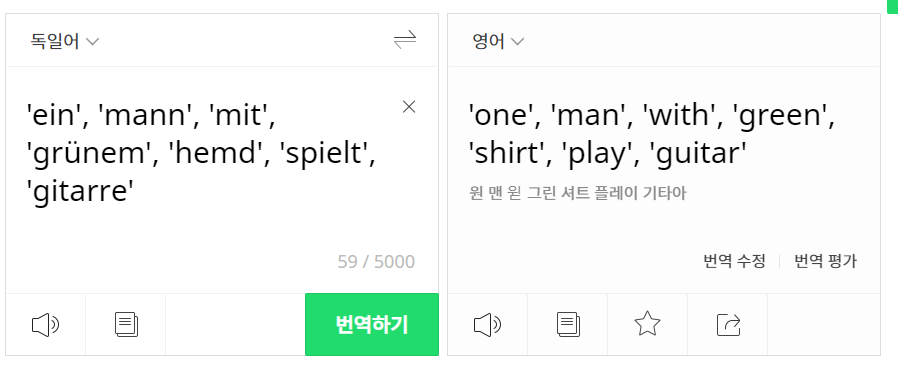